<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\a}{\mathbf{a}}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\indi}{\mathbb{I}}
$$

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# preamble
import sys
sys.path.append("..")
import statnlpbook.transition as transition

# Transition-based dependency parsing

This chapter is influenced by the [EACL 2014 tutorial](http://stp.lingfil.uu.se/~nivre/eacl14.html) by Ryan McDonald and Joakim Nivre.

In the [parsing chapter](parsing.ipynb) we saw how to develop a syntactic parser based on context-free grammars (CFG). In this chapter we will see how to develop a syntactic parser based on a different paradigm, dependency parsing.

The key idea in dependency parsing is that syntactic structure of lexical items, linked by binary
asymmetric relations called dependencies. [Nivre, 2008](http://www.mitpressjournals.org/doi/pdf/10.1162/coli.07-056-R1-07-027) More simply, syntax is represented as directed edges between words, commonly referred to arcs in the literature. Thus unlike the trees in [CFG parsing](parsing.ipynb), dependency trees have only terminal nodes (the words of the sentences), which can appear as leaves as and non-leaf nodes. Here is the dependency graph for the sentence:

> "Economic news had little effect on financial markets"

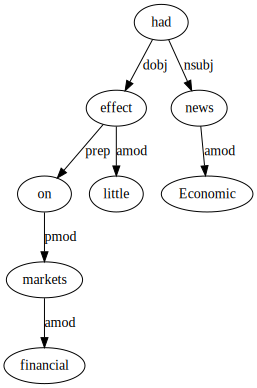

In [2]:
tokens = ["Economic", "news", "had", "little", "effect", "on", "financial", "markets", "."]
arcs = set([(1,0,"amod"),(2,1,"nsubj"), (2, 4, "dobj"), (4,3,"amod"), (4,5, "prep"), (5,7,"pmod"), (7,6,"amod")])

transition.render_tree(tokens, arcs)

Following [Nivre (2008)](http://www.mitpressjournals.org/doi/pdf/10.1162/coli.07-056-R1-07-027), the dependency parse of a sentence is a graph \\(\y = (\x, \a) \\) where:
- \\(\x = \\{0, 1, ... N\\}\\) are the nodes, each of them representing one of the N words in the sentence
- \\(\a \subseteq \x \times \x \times L \\) are labeled directed arcs between the words, with labels coming from a predefined set \\(L\\).

For a graph \\(\y\\) to be a valid dependency tree, the following constrains must be obeyed:

- rooted: node 0 is the root and there can be no incoming arcs to it
- acyclic: no directed cycles exist in \\(\y\\) 
- single-headed: each node can only one head node, i.e. only one incoming arc
- connected: there is an undirected path between every pair of nodes in the graph. 

Note that the dependency parse tree shown above is not connected since the period is left without an arc (it is a dependency *forrest*). To ensure that dependency trees are well-formed, we introduce a ROOT node which points to the main verb of the sentence, as well as the punctuation.

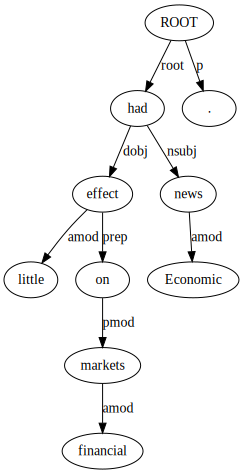

In [3]:
tokens = ["ROOT", "Economic", "news", "had", "little", "effect", "on", "financial", "markets", "."]
arcs = set([(0,3, "root"), (0,9,"p"), (2,1,"amod"),(3,2,"nsubj"), (3, 5, "dobj"), (5,4,"amod"), (5,6, "prep"), (6,8,"pmod"), (8,7,"amod")])

transition.render_tree(tokens, arcs)

A straightforward approach to dependency parsing would be given a sentence \\(\x\\), to enumerate over all valid graphs for the sentence $\y\in\Ys_x$ and score them using an appropriate function \\(s_\params(\x,\y)\\), a case of a [structured prediction](structured_prediction.ipynb) problem. While such an approach is possible and there has been a lot of work often referred to as graph-based parsing, e.g. [McDonald et al. (2006)](http://www.ryanmcd.com/papers/MS-CIS-05-11.pdf), in this note we will focus on transition-based approaches, which decompose the task into a sequence of label predictions that can be learned with a classifier.

To perform transition-based parsing we first need to define a transition system consisting of the following elements:

**Configuration**:
- Stack \\(S\\): a last-in, first-out memory to keep track of words to process later
- Buffer \\(B\\): words not processed so far
- Arcs \\(A\\): the dependency edges predicted so far

We further define two special configurations:
- initial: buffer is initialized to the words in the sentence, stack and arks are empty
- terminal: buffer is empty

**Actions**:
- shift: push the word at the top of the buffer to the stack \\((S, i|B, A)\rightarrow(S|i, B, A)\\)
- reduce: pop the word at the top of the stack if it has a head \\((S|i, B, A)\rightarrow(S, B, A)\\)
- rightArc-label: create a labeled arc from the word at the top of the stack \\(i\\) to the word at the top of the buffer \\(j\\) \\((S|i, j|B, A) \rightarrow (S|i|j, B, A\cup\{(i,j,l)\})\\)
- leftArc-label: create a labeled arc from the word at the top of the buffer \\(j\\) to the word at the top of the stack \\(i\\) if \\(i\\) has no head \\((S|i, j|B, A) \rightarrow (S, j|B, A\cup\{(j,i,l)\})\\)

Below we show a simple implementation of this transition system:

In [4]:
from collections import deque

class Configuration():
    def __init__(self, tokenized_sentence):
        # This implements the initial configuration for a sentence
        self.arcs = set()
        self.buffer = deque()
        for idx, token in enumerate(tokenized_sentence):
            self.buffer.append(token+ "_" + str(idx))
        self.stack = []
        
import copy
def parse(tokenized_sentence, actions):
    # This stores the (configuration, action) tuples generated
    transitions = []
    
    # Initialize the configuration
    configuration = Configuration(tokenized_sentence)
    transitions.append((copy.deepcopy(configuration), "INIT"))
    
    for action in actions:
        if action == "shift":
            token = configuration.buffer.popleft()
            configuration.stack.append(token)
        elif action == "reduce":
            # check if it is headed already:
            headed = False
            for arc in configuration.arcs:
                if arc[1] == int(dependentTokenId):
                    headed = True
            if not headed:
                raise Exception("Token at the top of the stack does not have an incoming edge.")
            
            configuration.stack.pop()
        elif action.startswith("leftArc"):
            # Get the dependent token
            dependentToken, dependentTokenId = configuration.stack.pop().split("_")

            # check if it is headed already:
            headed = False
            for arc in configuration.arcs:
                if arc[1] == int(dependentTokenId):
                    headed = True
            if headed:
                raise Exception("Dependent token has an incoming edge already")
            
            label = action.split("-")[1]
            headToken, headTokenId = configuration.buffer[0].split("_")
            
            configuration.arcs.add((int(headTokenId),int(dependentTokenId),label))

        elif action.startswith("rightArc"):
            label = action.split("-")[1]            
            
            dependent = configuration.buffer.popleft()
            dependentToken, dependentTokenId = dependent.split("_")
            headToken, headTokenId = configuration.stack[-1].split("_")
            
            configuration.arcs.add((int(headTokenId),int(dependentTokenId),label))
            
            configuration.stack.append(dependent)
            
        
        transitions.append((copy.deepcopy(configuration), action))
    
    if len(configuration.buffer) == 0:
        transitions.append((copy.deepcopy(configuration), "TERMINAL"))
    return transitions

Let's see how we can parse the example sentence using this transition system defined above assuming we are given the correct sequence of actions:

In [5]:
tokenized_sentence = ["ROOT", "Economic", "news", "had", "little", "effect", "on", "financial", "markets", "."]
actions = ["shift","shift", "leftArc-amod", "shift", "leftArc-nsubj", "rightArc-root", "shift", "leftArc-amod", "rightArc-dobj", "rightArc-prep", "shift", "leftArc-amod", "rightArc-pmod", "reduce", "reduce", "reduce", "reduce", "rightArc-p"]

transitions = parse(tokenized_sentence, actions)

transition.render_transitions(transitions, tokenized_sentence)

buffer,stack,parse,action
ROOT_0 Economic_1 news_2 had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",INIT
Economic_1 news_2 had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",shift
news_2 had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0 Economic_1,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",shift
news_2 had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 2 --> 2 news <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod",leftArc-amod
had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0 news_2,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 2 --> 2 news <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod",shift
had_3 little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 3 --> 3 had <!-- 2 --> 2 news <!-- 3->2 --> 3->2 nsubj <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod",leftArc-nsubj
little_4 effect_5 on_6 financial_7 markets_8 ._9,ROOT_0 had_3,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 ROOT <!-- 3 --> 3 had <!-- 0->3 --> 0->3 root <!-- 2 --> 2 news <!-- 3->2 --> 3->2 nsubj <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod",rightArc-root
effect_5 on_6 financial_7 markets_8 ._9,ROOT_0 had_3 little_4,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 ROOT <!-- 3 --> 3 had <!-- 0->3 --> 0->3 root <!-- 2 --> 2 news <!-- 3->2 --> 3->2 nsubj <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod",shift
effect_5 on_6 financial_7 markets_8 ._9,ROOT_0 had_3,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 0 --> 0 ROOT <!-- 3 --> 3 had <!-- 0->3 --> 0->3 root <!-- 2 --> 2 news <!-- 3->2 --> 3->2 nsubj <!-- 5 --> 5 effect <!-- 4 --> 4 little <!-- 5->4 --> 5->4 amod <!-- 1 --> 1 Economic <!-- 2->1 --> 2->1 amod",leftArc-amod
on_6 financial_7 markets_8 ._9,ROOT_0 had_3 effect_5,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1

The key idea in transition dependency parsing is that we converted graph prediction, a structured prediction problem, into a sequence of classification predictions that are guaranteed to give us a valid dependency tree. Thus a transition based dependency parser is a classifier that predicts the correct action for the current configuration. 

The choice of classifier is free; we can use any classifier we like, for example [loglinear classification models](doc_classify.ipynb). The features are defined in order to describe the configuration and the previous actions taken in a way that helps the classifier predict the correct action. For example, encoding that the words on top of the buffer and the stack are "on" and "effect" respectively is highly indicative of the rightArc-prep action to create an arc between them. Such lexicalized features though can be quite sparse, which is why recent work has looked into continuous representations for them ([Chen and Manning, 2014](http://cs.stanford.edu/people/danqi/papers/emnlp2014.pdf)).

The next question is where we get the training data to train the classifier, i.e. configurations labeled with the correct action. However the training data we are typically provided with consists of sentences labeled with the final dependency tree. Thus, we need to develop a function that given a sentence and its dependency tree can "reverse-engineer" the parsing process to recover the sequence of actions that was used construct it. This function is often referred to as the oracle (name inspired by [the ones in antiquity](https://en.wikipedia.org/wiki/Oracle)), and it is usually a set of heuristics that returns the correct sequence of actions by looking at the dependency tree. A different way to think about it is that of a human annotator demonstrating how to construct the parse tree using the transition system defined.

The transition system we defined above is known as the arc-eager system due to [Nivre (2003)](http://stp.lingfil.uu.se/~nivre/docs/iwpt03.pdf). Different transition systems have been proposed, another popular choice being the arc-standard transition system that has three actions, left-arc, right-arc and shift that are defined differently compared to the arc-eager ones. As expected, different transition systems have different oracles to extract configurations labeled with the correct transition action from sentences annotated with dependency trees.

An important restriction that both the arc-eager and arc-standard transition systems have is that they can only produce  projective dependency trees, i.e. trees that when they are drawn having the words on a fixed left-to-right order their arcs do not cross. However this restriction is violated when long-distance dependencies and free word order need to be taken into account, as in the sentence below:

![](http://andreasvlachos.github.io/assets/lectures_reveal_js/images/tikz/depParseNonProjective.png)

To produce non-projective dependency trees such as the on in the example above, more complex transition systems employing mulitple stacks have been developed ([Gomez-Rodriguez and Nivre, 2010](http://www.aclweb.org/anthology/P10-1151)).

Another issue in transition-based dependency parsing is that given a sentence, multiple action sequences can produce the same dependency tree. For example:






In [7]:
sentence = ["He", "wrote", "her", "a", "letter"]
actions1 = ["shift", "leftArc-nsubj", "shift", "rightArc-iobj", "reduce", "shift", "leftArc-det", "rightArc-dobj"]

transitions1 = parse(sentence, actions1)

transition.render_transitions(transitions1, sentence)

buffer,stack,parse,action
He_0 wrote_1 her_2 a_3 letter_4,,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",INIT
wrote_1 her_2 a_3 letter_4,He_0,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",shift
wrote_1 her_2 a_3 letter_4,,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj",leftArc-nsubj
her_2 a_3 letter_4,wrote_1,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj",shift
a_3 letter_4,wrote_1 her_2,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj",rightArc-iobj
a_3 letter_4,wrote_1,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj",reduce
letter_4,wrote_1 a_3,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj",shift
letter_4,wrote_1,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj <!-- 4 --> 4 letter <!-- 3 --> 3 a <!-- 4->3 --> 4->3 det",leftArc-det
,wrote_1 letter_4,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj <!-- 4 --> 4 letter <!-- 1->4 --> 1->4 dobj <!-- 3 --> 3 a <!-- 4->3 --> 4->3 det",rightArc-dobj
,wrote_1 letter_4,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj <!-- 4 --> 4 letter <!-- 1->4 --> 1->4 dobj <!-- 3 --> 3 a <!-- 4->3 --> 4->3 det",TERMINAL


In [9]:
sentence = ["He", "wrote", "her", "a", "letter"]
actions2 = ["shift", "leftArc-nsubj", "shift", "rightArc-iobj", "shift", "leftArc-det", "reduce", "rightArc-dobj"]

transitions2 = parse(sentence, actions2)

transition.render_transitions(transitions2, sentence)

buffer,stack,parse,action
He_0 wrote_1 her_2 a_3 letter_4,,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",INIT
wrote_1 her_2 a_3 letter_4,He_0,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3",shift
wrote_1 her_2 a_3 letter_4,,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj",leftArc-nsubj
her_2 a_3 letter_4,wrote_1,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj",shift
a_3 letter_4,wrote_1 her_2,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj",rightArc-iobj
letter_4,wrote_1 her_2 a_3,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj",shift
letter_4,wrote_1 her_2,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj <!-- 4 --> 4 letter <!-- 3 --> 3 a <!-- 4->3 --> 4->3 det",leftArc-det
letter_4,wrote_1,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj <!-- 4 --> 4 letter <!-- 3 --> 3 a <!-- 4->3 --> 4->3 det",reduce
,wrote_1 letter_4,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj <!-- 4 --> 4 letter <!-- 1->4 --> 1->4 dobj <!-- 3 --> 3 a <!-- 4->3 --> 4->3 det",rightArc-dobj
,wrote_1 letter_4,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.38.0 (20140413.2041) --> <!-- Title: %3 Pages: 1 --> %3 <!-- 1 --> 1 wrote <!-- 2 --> 2 her <!-- 1->2 --> 1->2 iobj <!-- 0 --> 0 He <!-- 1->0 --> 1->0 nsubj <!-- 4 --> 4 letter <!-- 1->4 --> 1->4 dobj <!-- 3 --> 3 a <!-- 4->3 --> 4->3 det",TERMINAL


The two action sequences, `actions1` and `actions2` are differnt, but they result in the same dependency tree. In order to capture this ambiguity, recent work has developed *dynamic oracles* ([Goldberg and Nivre, 2013](http://www.aclweb.org/anthology/Q/Q13/Q13-1033.pdf)), that generate labeled configurations for the same sentence along multiple action sequences, and thus providing better training data to learn the classifiers. Dynamic oracles is task-specific reincarnation of the concept of *expert policy*, which was originally developed in the context of robotics ([Ross et al., 2011](http://www.cs.cmu.edu/~sross1/publications/Ross-AIStats11-NoRegret.pdf)).